<a href="https://colab.research.google.com/github/alessandropessoa/HateBR/blob/main/desaprendizado_de_maquina_bert_random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Paper

https://ieeexplore.ieee.org/abstract/document/9519428?casa_token=RoZCE-WI7asAAAAA:3AsNvVmcatupCfR0sF_32xV1s6S5-uRMC4JU8zovlerPiaYR2G64rOaTTgoC3mhag_iHmmaVaB8

O pipeline utiliza o framework SISA com RandomForestClassifier e embeddings do BERT para classificar textos com alta precisão, enquanto garante a privacidade dos dados por meio de machine unlearning. O BERT extrai representações contextuais robustas, o RF classifica essas representações de forma eficiente, e o SISA permite remover dados específicos rapidamente, retreinando apenas os shards afetados. Testes empíricos mostram que as predições após o unlearning são consistentes com um modelo treinado sem os dados removidos,  atendendo a requisitos de privacidade como o GDPR

#referencias principais

https://ieeexplore.ieee.org/abstract/document/9519428?casa_token=RoZCE-WI7asAAAAA:3AsNvVmcatupCfR0sF_32xV1s6S5-uRMC4JU8zovlerPiaYR2G64rOaTTgoC3mhag_iHmmaVaB8

https://aclanthology.org/2022.lrec-1.777/

https://www.cambridge.org/core/journals/natural-language-processing/article/contextaware-and-expert-data-resources-for-brazilian-portuguese-hate-speech-detection/7D9019ED5471CD16E320EBED06A6E923#}

https://aclanthology.org/2025.coling-main.446/

https://www.tandfonline.com/doi/full/10.1080/01431160412331269698

#Justificativa

Justificativa técnica
A escolha do SISA com RF e BERT é justificada pelos seguintes pontos:

* BERT: Fornece embeddings state-of-the-art para textos, capturando relações semânticas complexas que outros métodos (e.g., TF-IDF) não conseguem. Sua pré-computação (salva com save_embeddings) garante eficiência em pipelines iterativos.
* RandomForestClassifier: É ideal para embeddings de alta dimensionalidade (768 dimensões do BERT) devido à sua capacidade de lidar com features correlacionadas e sua natureza ensemble, que reduz overfitting. Além disso, RFs são compatíveis com o SISA, pois podem ser treinados independentemente em cada shard.
* SISA: Oferece uma solução prática para machine unlearning, essencial em cenários onde a privacidade é crítica. O paper Machine Unlearning (Bourtoule et al., 2021) demonstra que o SISA reduz significativamente o tempo de unlearning (e.g., até 4.63x para o dataset Purchase), tornando-o adequado para aplicações reais.

In [ ]:
%%capture
!pip install transformers torch scikit-learn pandas numpy datasets

#Importação dos pacotes


In [1]:
import pandas as pd
import numpy as np
import torch
from datasets import load_dataset
from transformers import BertTokenizer, BertModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import mode
import time


In [2]:
import seaborn as sns

In [ ]:
from datetime import datetime
import os
from google.colab import drive

In [3]:
import matplotlib.pyplot as plt

In [4]:
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image

In [5]:
from google.colab import drive

# Carga do dataset e análise exploratória

$$
\begin{array}{|l|c|r|}
\hline
\textbf{Anotação} & \textbf{Rótulo} & \textbf{Total} \\
\hline
\text{Ofensiva} & 1 & 3.500 \\
\text{Não ofensivo} & 0 & 3.500 \\
\hline
\textbf{Total} & & \textbf{7.000} \\
\hline
\end{array}
$$

In [7]:
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
df_hateBr= pd.read_csv("/content/drive/MyDrive/desaprendizado-de-maquina/HateBR.csv")

In [9]:
df_hateBr

,id,comentario,anotator1,anotator2,anotator3,label_final,links_post,account_post
0,1,Mais um lixo,1,1,1,1,https://www.instagram.com/p/B2uThqdH9xI/,Carla Zambelli
1,2,Essa nao tem vergonha na cara!!,1,1,1,1,https://www.instagram.com/p/B2uThqdH9xI/,Carla Zambelli
2,3,Essa mulher é doente.pilantra!,1,1,1,1,https://www.instagram.com/p/B2uThqdH9xI/,Carla Zambelli
3,4,Comunista safada...,1,1,1,1,https://www.instagram.com/p/B2uThqdH9xI/,Carla Zambelli
4,5,Vagabunda. Comunista. Mentirosa. O povo chilen...,1,1,1,1,https://www.instagram.com/p/B2uThqdH9xI/,Carla Zambelli
...,...,...,...,...,...,...,...,...
6995,6996,Parabéns Eduardo!!! Deus te proteja. Obrigada ...,0,0,0,0,https://www.instagram.com/p/C5rDlbTPTJq/,Eduardo Bolsonaro
6996,6997,A melhor maneira de unir a direita do mundo to...,0,0,0,0,https://www.instagram.com/p/C5rDlbTPTJq/,Eduardo Bolsonaro
6997,6998,Vcs são lutadores. Sejam protegidos.,0,0,0,0,https://www.instagram.com/p/C5rDlbTPTJq/,Eduardo Bolsonaro
6998,6999,"Parabéns Deus abençoe 🙌, que a verdade traga a...",0,0,0,0,https://www.instagram.com/p/C5rDlbTPTJq/,Eduardo Bolsonaro


In [21]:
aux = df_hateBr['comentario'].apply(lambda x: len(x.split()))
aux

,comentario
0,3
1,6
2,4
3,2
4,11
...,...
6995,9
6996,10
6997,5
6998,10


In [22]:
aux.describe()

,comentario
count,7000.000000
mean,13.933857
std,14.473542
min,1.000000
25%,6.000000
50%,9.000000
75%,17.000000
max,189.000000


In [23]:
aux[aux == aux.max()]

,comentario
3299,189


In [25]:
max_text_corpus = df_hateBr['comentario'].iloc[3299]
max_text_corpus

'O meu pais tem potencial de expansão, Não são comentarios de Javier Milei sobre o ocidente está em perigo ou a classificação do meu pais como inseguro pelos Eua para o turismo principalmente no Rio e são paulo coincidentemente em Janeiro de 2024.Isso são tentativas de manipular a população mesmo usando alguns fatos, estão estimulando a não investirem no meu pais para parar o crescimento do meu pais em meio a ascenção da inteligência artificial e os investimentos em educação.Por meio da educação vem a inovação são as duas armas para mudar o pais.O meu pais estimulara o yurismo a educação e a inovação esse é o momento aproveitarmos o boom da inteligência artificial e mudar o pais.Pedir a ajuda de Bill Gates para investir na internet gratuita e assim termos acesso a informações para a inovação ,ou convencê-lo a abrir um novo empreendimento no pais, através dele virá outros investidores internacionais a hora do pais mudar é agora."Turismo internacional disparou 62,7% no Brasil em 2023 Arg

In [ ]:
df_hateBrXplain= pd.read_csv("/content/drive/MyDrive/desaprendizado-de-maquina/HateBRXplain.csv")

In [ ]:
df_hateBrXplain

,id,comment,offensive_label,link_post,rationales_annotator1,rationales_annotator2
0,1,Mais um lixo,1,https://www.instagram.com/p/B2uThqdH9xI/,Mais um lixo,mais um lixo
1,2,Essa nao tem vergonha na cara!!,1,https://www.instagram.com/p/B2uThqdH9xI/,Essa nao tem vergonha na cara,nao tem vergonha na cara
2,3,Essa mulher é doente.pilantra!,1,https://www.instagram.com/p/B2uThqdH9xI/,doente; pilantra,doente; pilantra
3,4,Comunista safada...,1,https://www.instagram.com/p/B2uThqdH9xI/,Comunista safada,comunista; safada
4,5,Vagabunda. Comunista. Mentirosa. O povo chilen...,1,https://www.instagram.com/p/B2uThqdH9xI/,Vagabunda. Comunista. Mentirosa; desgraça desta,comunista; mentirosa; nao merece uma desgraça ...
...,...,...,...,...,...,...
6995,6996,Parabéns Eduardo!!! Deus te proteja. Obrigada ...,0,https://www.instagram.com/p/C5rDlbTPTJq/,NaN,NaN
6996,6997,A melhor maneira de unir a direita do mundo to...,0,https://www.instagram.com/p/C5rDlbTPTJq/,NaN,NaN
6997,6998,Vcs são lutadores. Sejam protegidos.,0,https://www.instagram.com/p/C5rDlbTPTJq/,NaN,NaN
6998,6999,"Parabéns Deus abençoe 🙌, que a verdade traga a...",0,https://www.instagram.com/p/C5rDlbTPTJq/,NaN,NaN


In [ ]:
df_hateBr.account_post.unique()

array(['Carla Zambelli', 'Eduardo Bolsonaro', 'Fernando Haddad',
       "Manuela d'Ávila", 'Gleisi Hoffmann', 'Joice Hasselmann'],
      dtype=object)

In [ ]:
df_hateBr.groupby('account_post').count()

,id,comentario,anotator1,anotator2,anotator3,label_final,links_post
account_post,,,,,,,
Carla Zambelli,1481,1481,1481,1481,1481,1481,1481
Eduardo Bolsonaro,1151,1151,1151,1151,1151,1151,1151
Fernando Haddad,1118,1118,1118,1118,1118,1118,1118
Gleisi Hoffmann,834,834,834,834,834,834,834
Joice Hasselmann,1158,1158,1158,1158,1158,1158,1158
Manuela d'Ávila,1258,1258,1258,1258,1258,1258,1258


In [ ]:
df_hateBr[df_hateBr['label_final']==1].groupby('account_post').count()

,id,comentario,anotator1,anotator2,anotator3,label_final,links_post
account_post,,,,,,,
Carla Zambelli,990,990,990,990,990,990,990
Eduardo Bolsonaro,414,414,414,414,414,414,414
Fernando Haddad,264,264,264,264,264,264,264
Gleisi Hoffmann,439,439,439,439,439,439,439
Joice Hasselmann,695,695,695,695,695,695,695
Manuela d'Ávila,698,698,698,698,698,698,698


In [ ]:
df_hateBr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            7000 non-null   int64 
 1   comentario    7000 non-null   object
 2   anotator1     7000 non-null   int64 
 3   anotator2     7000 non-null   int64 
 4   anotator3     7000 non-null   int64 
 5   label_final   7000 non-null   int64 
 6   links_post    7000 non-null   object
 7   account_post  7000 non-null   object
dtypes: int64(5), object(3)
memory usage: 437.6+ KB


# Dividindo em treino e teste

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df_hateBr['comentario'].tolist(), df_hateBr['label_final'].tolist(), test_size=0.2, random_state=42, stratify=df_hateBr['label_final'].tolist()
)

In [ ]:
print(f"\n{len(X_train)} amostras de treino, {len(X_test)} amostras de teste.")


5600 amostras de treino, 1400 amostras de teste.


#Carregando modelo de lingaguem (BERTimbau)

In [27]:
MODEL_NAME = 'neuralmind/bert-base-portuguese-cased'
MAX_LENGTH = 512
BATCH_SIZE = 16
VERSION = 'v1'

In [28]:
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
model = BertModel.from_pretrained('neuralmind/bert-base-portuguese-cased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [29]:
model.config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.52.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 29794
}

In [35]:
max_text_corpus

'O meu pais tem potencial de expansão, Não são comentarios de Javier Milei sobre o ocidente está em perigo ou a classificação do meu pais como inseguro pelos Eua para o turismo principalmente no Rio e são paulo coincidentemente em Janeiro de 2024.Isso são tentativas de manipular a população mesmo usando alguns fatos, estão estimulando a não investirem no meu pais para parar o crescimento do meu pais em meio a ascenção da inteligência artificial e os investimentos em educação.Por meio da educação vem a inovação são as duas armas para mudar o pais.O meu pais estimulara o yurismo a educação e a inovação esse é o momento aproveitarmos o boom da inteligência artificial e mudar o pais.Pedir a ajuda de Bill Gates para investir na internet gratuita e assim termos acesso a informações para a inovação ,ou convencê-lo a abrir um novo empreendimento no pais, através dele virá outros investidores internacionais a hora do pais mudar é agora."Turismo internacional disparou 62,7% no Brasil em 2023 Arg

In [36]:
vrf_max_text_corpus_token = tokenizer( max_text_corpus, return_tensors="pt", padding=True, truncation=True, max_length=512)
vrf_max_text_corpus_token

{'input_ids': tensor([[  101,   231,  7343,  2639,   376,  5323,   125,  4652,   117,  2542,
           453, 13052,   501,   125,   993, 17960,  2209,   244,   498,   146,
         16441,   698,   173,  9538,   291,   123,  4179,   171,  7343,  2639,
           271, 21148,   157,   954,  3396, 22278,   221,   146,  8003,  1953,
           202,  1007,   122,   453,  4735, 22280, 20026,  2214,   173,  1455,
           125, 14979, 22336,   119,  3393,   453,  7357,   125,  8605,   711,
           123,  1521,   653,  3414,  1089,  8446,   117,  1376, 16405,   348,
           123,   346, 17368,   210,   202,  7343,  2639,   221,  9079,   146,
          3340,   171,  7343,  2639,   173,  1423,   123, 10681, 22285,   182,
           180,  8224, 11507,   122,   259,  9159,   173,  3478,   119,   566,
          1423,   180,  3478,  3539,   123, 13309,   453,   260,   924,  3191,
           221,  5698,   146,  2639,   119,   231,  7343,  2639, 20149, 22278,
           146,  4759, 10866, 22281,  

In [39]:
dic_token_max = {}
for token_id in vrf_max_text_corpus_token['input_ids'][0]:
  token = tokenizer.decode(token_id)
  dic_token_max[token] = token_id.item()
  print(f"Palavra: {token}, Token ID: {token_id.item()}")

Palavra: [CLS], Token ID: 101
Palavra: O, Token ID: 231
Palavra: meu, Token ID: 7343
Palavra: pais, Token ID: 2639
Palavra: tem, Token ID: 376
Palavra: potencial, Token ID: 5323
Palavra: de, Token ID: 125
Palavra: expansão, Token ID: 4652
Palavra: ,, Token ID: 117
Palavra: Não, Token ID: 2542
Palavra: são, Token ID: 453
Palavra: comentar, Token ID: 13052
Palavra: ##ios, Token ID: 501
Palavra: de, Token ID: 125
Palavra: Ja, Token ID: 993
Palavra: ##vier, Token ID: 17960
Palavra: Mil, Token ID: 2209
Palavra: ##ei, Token ID: 244
Palavra: sobre, Token ID: 498
Palavra: o, Token ID: 146
Palavra: ocidente, Token ID: 16441
Palavra: está, Token ID: 698
Palavra: em, Token ID: 173
Palavra: perigo, Token ID: 9538
Palavra: ou, Token ID: 291
Palavra: a, Token ID: 123
Palavra: classificação, Token ID: 4179
Palavra: do, Token ID: 171
Palavra: meu, Token ID: 7343
Palavra: pais, Token ID: 2639
Palavra: como, Token ID: 271
Palavra: insegu, Token ID: 21148
Palavra: ##ro, Token ID: 157
Palavra: pelos, Toke

In [41]:
len(dic_token_max)

154

#mover modelo para GPU

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(29794, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

#Função para gerar Embeddings

In [ ]:
def get_bert_embeddings_batch(texts, batch_size=32):
    model.eval()
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        all_embeddings.extend(cls_embeddings)
    return np.array(all_embeddings)

# Função para salvar embeddings

In [ ]:
drive.mount('/content/drive')
SAVE_DIR = '/content/drive/MyDrive/Desaprendizado-de-maquina/embeddings'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def save_embeddings(embeddings, labels, dataset_name, save_dir=SAVE_DIR, version=VERSION):
    os.makedirs(save_dir, exist_ok=True)

    # Criar nome do arquivo com timestamp para versionamento
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    file_prefix = f'{dataset_name}_embeddings_{version}_{timestamp}'

    # Salvar embeddings em formato .npy
    np.save(os.path.join(save_dir, f'{file_prefix}.npy'), embeddings)

    # Salvar metadados em um arquivo JSON
    metadata = {
        'model_name': MODEL_NAME,
        'max_length': MAX_LENGTH,
        'batch_size': BATCH_SIZE,
        'dataset_name': dataset_name,
        'version': version,
        'timestamp': timestamp,
        'num_samples': len(embeddings),
        'embedding_dim': embeddings.shape[1]
    }
    pd.DataFrame([metadata]).to_json(os.path.join(save_dir, f'{file_prefix}_metadata.json'), indent=4)

    # Salvar labels, se fornecidos
    if labels is not None:
        np.save(os.path.join(save_dir, f'{file_prefix}_labels.npy'), labels)

In [ ]:
print("\nGerando embeddings ...")
X_train_emb = get_bert_embeddings_batch(X_train)
X_test_emb = get_bert_embeddings_batch(X_test)
print("Embeddings Gerados.")


Gerando embeddings ...
Embeddings Gerados.


In [ ]:
save_embeddings(X_train_emb, y_train, "train")
save_embeddings(X_test_emb, y_test, "test")

# Carregar Embeddings do disco

In [ ]:
embeddings_file_path_test  = '/content/drive/MyDrive/desaprendizado-de-maquina/embeddings/test_embeddings_v1_20250530_163204.npy'
embeddings_file_path_train = '/content/drive/MyDrive/desaprendizado-de-maquina/embeddings/train_embeddings_v1_20250530_163204.npy'

In [ ]:
def carregar_embeddings(file_path):
  try:
      embeddings = np.load(file_path)
      print(f"Embeddings carregados com sucesso! Formato: {embeddings.shape}")
      print(f"Primeiros 5 embeddings:\n{embeddings[:5]}")
      return embeddings
  except FileNotFoundError:
      print(f"Erro: O arquivo '{embeddings_file_path}' não foi encontrado.")
  except Exception as e:
      print(f"Ocorreu um erro ao carregar os embeddings: {e}")

In [ ]:
X_train_emb = carregar_embeddings(embeddings_file_path_train)

Embeddings carregados com sucesso! Formato: (5600, 768)
Primeiros 5 embeddings:
[[ 0.32961616  0.23837833  0.28782025 ... -0.37198535 -0.07935924
  -0.10853322]
 [ 0.17227432  0.291673   -0.00551119 ... -0.2846312  -0.13850759
  -0.01124104]
 [ 0.5018348  -0.09245382  0.07460089 ... -0.2964913  -0.146441
  -0.3132075 ]
 [ 0.15090333  0.4267243   0.4289793  ... -0.367706    0.19809301
  -0.25171554]
 [ 0.35436648  0.43083784  0.0556081  ... -0.22054864 -0.0989911
  -0.25134042]]


In [ ]:
X_test_emb = carregar_embeddings(embeddings_file_path_test)

Embeddings carregados com sucesso! Formato: (1400, 768)
Primeiros 5 embeddings:
[[ 0.37995148  0.39687076  0.11825089 ... -0.289695   -0.2552725
  -0.5103379 ]
 [ 0.0229261   0.47970286 -0.17891477 ... -0.4697935   0.09265439
   0.12577282]
 [ 0.24029234  0.34230435 -0.3214184  ... -0.10461382 -0.09635372
  -0.12562893]
 [ 0.24947557  0.34123656  0.23425396 ... -0.6319584  -0.14628549
   0.23989014]
 [ 0.06239241  0.1238482   0.48415098 ... -0.466122    0.16593625
  -0.19470266]]


#Treinando Modelo RF (classificador), só para teste pos o SISA terá o classificador dentro da função

In [ ]:
rf_base = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    min_samples_leaf=5,  # Mínimo de 5 amostras por folha
    criterion="gini"      # ou "entropy" para usar entropia
)


In [ ]:
rf_base_entropia = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    min_samples_leaf=5,  # Mínimo de 5 amostras por folha
    criterion="entropy"      # ou "entropy" para usar entropia
)

In [ ]:
rf_base.fit(X_train_emb, y_train)

RandomForestClassifier(min_samples_leaf=5, n_jobs=-1, random_state=42)

In [ ]:
rf_base_entropia.fit(X_train_emb, y_train)

RandomForestClassifier(criterion='entropy', min_samples_leaf=5, n_jobs=-1,
                       random_state=42)

In [ ]:
y_pred_base = rf_base.predict(X_test_emb)

In [ ]:
y_pred_base_entropia = rf_base_entropia.predict(X_test_emb)

##Performance do Modelo Classificador

In [ ]:
print(f"Acurácia com GINI: {accuracy_score(y_test, y_pred_base):.4f}")

Acurácia com GINI: 0.8400


In [ ]:
print(f"Acuráciacom Entropia: {accuracy_score(y_test, y_pred_base_entropia):.4f}")

Acuráciacom Entropia: 0.8379


## SITREP Métricas classficação

In [ ]:
print(classification_report(y_test, y_pred_base))

              precision    recall  f1-score   support

           0       0.84      0.85      0.84       700
           1       0.84      0.83      0.84       700

    accuracy                           0.84      1400
   macro avg       0.84      0.84      0.84      1400
weighted avg       0.84      0.84      0.84      1400



In [ ]:
pd.DataFrame(classification_report(y_test, y_pred_base, output_dict=True)).T

,precision,recall,f1-score,support
0,0.836158,0.845714,0.840909,700.00
1,0.843931,0.834286,0.839080,700.00
accuracy,0.840000,0.840000,0.840000,0.84
macro avg,0.840044,0.840000,0.839995,1400.00
weighted avg,0.840044,0.840000,0.839995,1400.00


#SISA

## SHARD

In [ ]:
N_SHARDS = 20 # Número de partições

In [ ]:
def train_sisa_rf(X_train_emb, y_train, n_shards=N_SHARDS):
    # Mantem um mapeamento do índice original para o shard/índice no shard
    indices = np.arange(len(y_train))

    # Embaralha antes de dividir para garantir distribuição
    shuffled_indices = np.random.permutation(indices)
    X_shuffled = X_train_emb[shuffled_indices]
    y_shuffled = np.array(y_train)[shuffled_indices] # Garante que é numpy array

    shards_X = np.array_split(X_shuffled, n_shards)
    shards_y = np.array_split(y_shuffled, n_shards)
    shards_indices = np.array_split(shuffled_indices, n_shards) # Mapeamento

    models = []
    for i in range(n_shards):
        rf = RandomForestClassifier(n_estimators=10, min_samples_leaf=5,random_state=42+i, n_jobs=-1)
        rf.fit(shards_X[i], shards_y[i])
        models.append(rf)

    return models, shards_X, shards_y, shards_indices

In [ ]:
def sisa_predict(X_test_emb, models):
    predictions = np.array([model.predict(X_test_emb) for model in models])
    final_preds, _ = mode(predictions, axis=0, keepdims=False)
    return final_preds


##Treinando Modelo SISA

In [ ]:
sisa_models, s_X, s_y, s_idx = train_sisa_rf(X_train_emb, y_train)

In [ ]:
y_pred_sisa = sisa_predict(X_test_emb, sisa_models)

##Performance do Modelo SISA (antes do unlearn)

In [ ]:
print(f"Acurácia: {accuracy_score(y_test, y_pred_sisa):.4f}")

Acurácia: 0.8114


In [ ]:
pd.DataFrame(classification_report(y_test, y_pred_sisa,output_dict=True)).T

,precision,recall,f1-score,support
0,0.801105,0.828571,0.814607,700.000000
1,0.822485,0.794286,0.808140,700.000000
accuracy,0.811429,0.811429,0.811429,0.811429
macro avg,0.811795,0.811429,0.811373,1400.000000
weighted avg,0.811795,0.811429,0.811373,1400.000000


#Unlearning

In [ ]:
# --- Lógica de Unlearning ---
def unlearn_sisa(indices_to_forget, models, shards_X, shards_y, shards_indices):
    indices_to_forget_set = set(indices_to_forget)
    retrained_shards = 0
    start_time = time.time()

    for i in range(len(shards_indices)):
        # Encontrar quais índices deste shard devem ser esquecidos
        shard_indices_set = set(shards_indices[i])
        common_indices = shard_indices_set.intersection(indices_to_forget_set)

        if common_indices:
            retrained_shards += 1
            print(f"Retreinando Shard {i} (encontrados {len(common_indices)} dados)...")

            # Máscara para manter os dados que NÃO devem ser esquecidos
            mask = np.isin(shards_indices[i], list(common_indices), invert=True)

            new_shard_X = shards_X[i][mask]
            new_shard_y = shards_y[i][mask]

            # Atualizar shards (importante para futuros unlearns)
            shards_X[i] = new_shard_X
            shards_y[i] = new_shard_y
            shards_indices[i] = shards_indices[i][mask] # Atualiza os índices

            # Retreinar
            rf = RandomForestClassifier(n_estimators=10, random_state=42+i, n_jobs=-1)
            if len(new_shard_y) > 0:
               rf.fit(new_shard_X, new_shard_y)
            else:
               print(f"Atenção: Shard {i} ficou vazio!")
               # Lidar com shard vazio (ex: modelo nulo ou remover da agregação)
               # Aqui, vamos criar um modelo "vazio" que não prevê nada
               # ou, idealmente, ajustar a lógica de predição para ignorá-lo.
               # Por simplicidade, mantemos um modelo recém-criado (não treinado).

            models[i] = rf


    end_time = time.time()
    print(f"Unlearning concluído em {end_time - start_time:.2f} segundos. {retrained_shards} shards retreinados.")
    return models, shards_X, shards_y, shards_indices

 ## Seleção aleatória de 100 índices para esquececimentoo

In [ ]:
# Selecionaa 100 índices para esquecer
indices_to_forget = np.random.choice(np.arange(len(y_train)), size=100, replace=False)

In [ ]:
indices_to_forget

array([5202, 1220, 5506, 4858, 3128, 5563, 1185, 3464, 5580, 3456, 4671,
       1825, 4607, 4436,  606, 1306, 1252, 4971, 5358, 3085, 2126, 2054,
        861, 4804, 2715, 4491, 2659, 2528, 1987, 2169,  475,  160,  798,
        415, 1467, 4699, 2853, 2010, 2256, 5538,   11, 1722, 3257, 3287,
       5381,  631, 4766, 4384, 5003, 5127, 1200, 3217, 4135, 5311, 4412,
       4325, 3904, 2008, 1633, 1944,   54,  750, 2745, 1393, 2265, 1890,
       4201, 2456, 1709, 2019, 2148, 5081, 3150, 1134, 3216, 3922, 1828,
       3740, 1022, 2679, 4538, 1247, 2120, 1841, 4370, 5572, 3253,  400,
       4353, 5367, 3293, 1830, 1854,   19, 3502,  310, 1794, 3537, 3004,
       2349])

## Seleção de uma conta para esquecimento

In [ ]:
df_hateBr[df_hateBr['label_final']==1].groupby('account_post').count()

,id,comentario,anotator1,anotator2,anotator3,label_final,links_post
account_post,,,,,,,
Carla Zambelli,990,990,990,990,990,990,990
Eduardo Bolsonaro,414,414,414,414,414,414,414
Fernando Haddad,264,264,264,264,264,264,264
Gleisi Hoffmann,439,439,439,439,439,439,439
Joice Hasselmann,695,695,695,695,695,695,695
Manuela d'Ávila,698,698,698,698,698,698,698


In [ ]:
selecao_para_remocao_LGPD = df_hateBr[(df_hateBr['account_post']=='Carla Zambelli') & (df_hateBr['label_final']==1)]
selecao_para_remocao_LGPD

,id,comentario,anotator1,anotator2,anotator3,label_final,links_post,account_post
0,1,Mais um lixo,1,1,1,1,https://www.instagram.com/p/B2uThqdH9xI/,Carla Zambelli
1,2,Essa nao tem vergonha na cara!!,1,1,1,1,https://www.instagram.com/p/B2uThqdH9xI/,Carla Zambelli
2,3,Essa mulher é doente.pilantra!,1,1,1,1,https://www.instagram.com/p/B2uThqdH9xI/,Carla Zambelli
3,4,Comunista safada...,1,1,1,1,https://www.instagram.com/p/B2uThqdH9xI/,Carla Zambelli
4,5,Vagabunda. Comunista. Mentirosa. O povo chilen...,1,1,1,1,https://www.instagram.com/p/B2uThqdH9xI/,Carla Zambelli
...,...,...,...,...,...,...,...,...
3470,3471,Vagabundo pinguço,1,1,1,1,https://www.instagram.com/p/C5RG9JWovk7/,Carla Zambelli
3471,3472,Analfabeto funcional,1,1,1,1,https://www.instagram.com/p/C5RG9JWovk7/,Carla Zambelli
3472,3473,O da esquerda é roubar,1,1,1,1,https://www.instagram.com/p/C5RG9JWovk7/,Carla Zambelli
3473,3474,Ainda tem gente que apoia esse verme,1,1,1,1,https://www.instagram.com/p/C5RG9JWovk7/,Carla Zambelli


In [ ]:
selecao_para_remocao_LGPD.index

Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       3465, 3466, 3467, 3468, 3469, 3470, 3471, 3472, 3473, 3474],
      dtype='int64', length=990)

In [ ]:
print(f"\nIniciando Unlearning para {len(selecao_para_remocao_LGPD.index)} amostras...")
sisa_models_unlearned,shards_X_unlearned, shards_y_unlearned, shards_indices_unlearned = unlearn_sisa(selecao_para_remocao_LGPD.index, sisa_models, s_X, s_y, s_idx)



Iniciando Unlearning para 990 amostras...
Retreinando Shard 0 (encontrados 40 dados)...
Retreinando Shard 1 (encontrados 58 dados)...
Retreinando Shard 2 (encontrados 43 dados)...
Retreinando Shard 3 (encontrados 54 dados)...
Retreinando Shard 4 (encontrados 46 dados)...
Retreinando Shard 5 (encontrados 52 dados)...
Retreinando Shard 6 (encontrados 46 dados)...
Retreinando Shard 7 (encontrados 51 dados)...
Retreinando Shard 8 (encontrados 48 dados)...
Retreinando Shard 9 (encontrados 46 dados)...
Retreinando Shard 10 (encontrados 41 dados)...
Retreinando Shard 11 (encontrados 57 dados)...
Retreinando Shard 12 (encontrados 37 dados)...
Retreinando Shard 13 (encontrados 52 dados)...
Retreinando Shard 14 (encontrados 57 dados)...
Retreinando Shard 15 (encontrados 44 dados)...
Retreinando Shard 16 (encontrados 54 dados)...
Retreinando Shard 17 (encontrados 57 dados)...
Retreinando Shard 18 (encontrados 64 dados)...
Retreinando Shard 19 (encontrados 43 dados)...
Unlearning concluído em 1.0

##Performance do Modelo SISA (depois do unlearn)

In [ ]:
print("\n:")
y_pred_sisa_unlearned = sisa_predict(X_test_emb, sisa_models_unlearned)
print(f"Acurácia: {accuracy_score(y_test, y_pred_sisa_unlearned):.4f}")


:
Acurácia: 0.8057


In [ ]:
pd.DataFrame(classification_report(y_test,  y_pred_sisa_unlearned,output_dict=True)).T

,precision,recall,f1-score,support
0,0.746544,0.925714,0.826531,700.000000
1,0.902256,0.685714,0.779221,700.000000
accuracy,0.805714,0.805714,0.805714,0.805714
macro avg,0.824400,0.805714,0.802876,1400.000000
weighted avg,0.824400,0.805714,0.802876,1400.000000


In [ ]:
sisa_models_unlearned

[RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42),
 RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=43),
 RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=44),
 RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=45),
 RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=46),
 RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=47),
 RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=48),
 RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=49),
 RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=50),
 RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=51),
 RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=52),
 RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=53),
 RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=54),
 RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=55),
 RandomForestClassif

In [ ]:
def gerar_tabela_comparativa_desempenho(y_test, y_pred_sisa_unlearned, y_pred_sisa):
    """
    Gera uma tabela comparativa do desempenho de classificação antes e depois do unlearning.

    Args:
        y_test (array-like): Rótulos verdadeiros para o conjunto de teste.
        y_pred_sisa_unlearned (array-like): Rótulos previstos após o processo de unlearning.
        y_pred_sisa (array-like): Rótulos previstos antes do processo de unlearning.

    Returns:
        pd.DataFrame: Um DataFrame contendo a tabela comparativa das métricas.
    """

    # Gerar os relatórios de classificação como DataFrames
    df_depois_unlearn = pd.DataFrame(classification_report(y_test, y_pred_sisa_unlearned, output_dict=True)).T
    df_antes_unlearn = pd.DataFrame(classification_report(y_test, y_pred_sisa, output_dict=True)).T

    # Criar um DataFrame para a tabela final
    tabela_final_data = []

    # Define the rows to include and their display names
    rows_to_process = {
        '0': 'Classe 0',
        '1': 'Classe 1',
        'macro avg': 'Média (Macro)',
        'weighted avg': 'Média (Ponderada)'
    }

    metrics_to_process = ['precision', 'recall', 'f1-score']
    metric_names_mapping = {
        'precision': 'Precisão',
        'recall': 'Recall',
        'f1-score': 'F1-Score'
    }


    for idx in rows_to_process.keys():
        row_antes = df_antes_unlearn.loc[idx]
        row_depois = df_depois_unlearn.loc[idx]

        for metric_type in metrics_to_process:
            metrica_nome = f"{metric_names_mapping[metric_type]} ({rows_to_process[idx]})"
            valor_antes = row_antes[metric_type]
            valor_depois = row_depois[metric_type]
            diferenca_absoluta = valor_depois - valor_antes
            diferenca_percentual = (diferenca_absoluta / valor_antes) * 100 if valor_antes != 0 else np.nan
            tabela_final_data.append([metrica_nome, valor_antes, valor_depois, diferenca_absoluta, diferenca_percentual])

    # Handle Accuracy separately as it's a single value row
    metrica_nome = "Acurácia"
    valor_antes = df_antes_unlearn.loc['accuracy', 'precision'] # Access accuracy from the 'accuracy' row
    valor_depois = df_depois_unlearn.loc['accuracy', 'precision'] # Access accuracy from the 'accuracy' row
    diferenca_absoluta = valor_depois - valor_antes
    diferenca_percentual = (diferenca_absoluta / valor_antes) * 100 if valor_antes != 0 else np.nan
    tabela_final_data.append([metrica_nome, valor_antes, valor_depois, diferenca_absoluta, diferenca_percentual])


    df_comparativa = pd.DataFrame(tabela_final_data, columns=['Métrica', 'Antes', 'Depois', 'Diferença Absoluta', 'Diferença Percentual'])

    # Formatar as colunas numéricas
    df_comparativa['Antes'] = df_comparativa['Antes'].map('{:.4f}'.format)
    df_comparativa['Depois'] = df_comparativa['Depois'].map('{:.4f}'.format)
    df_comparativa['Diferença Absoluta'] = df_comparativa['Diferença Absoluta'].map('{:.4f}'.format)

    # Formatar a coluna 'Diferença Percentual' como porcentagem
    df_comparativa['Diferença Percentual'] = df_comparativa['Diferença Percentual'].map('{:.2f}%'.format)

    return df_comparativa

### Análise da Magnitude e Direção da Mudança

In [ ]:
df_diferenca = gerar_tabela_comparativa_desempenho(y_test, y_pred_sisa_unlearned, y_pred_sisa)
df_diferenca

,Métrica,Antes,Depois,Diferença Absoluta,Diferença Percentual
0,Precisão (Classe 0),0.8011,0.7465,-0.0546,-6.81%
1,Recall (Classe 0),0.8286,0.9257,0.0971,11.72%
2,F1-Score (Classe 0),0.8146,0.8265,0.0119,1.46%
3,Precisão (Classe 1),0.8225,0.9023,0.0798,9.70%
4,Recall (Classe 1),0.7943,0.6857,-0.1086,-13.67%
5,F1-Score (Classe 1),0.8081,0.7792,-0.0289,-3.58%
6,Precisão (Média (Macro)),0.8118,0.8244,0.0126,1.55%
7,Recall (Média (Macro)),0.8114,0.8057,-0.0057,-0.70%
8,F1-Score (Média (Macro)),0.8114,0.8029,-0.0085,-1.05%
9,Precisão (Média (Ponderada)),0.8118,0.8244,0.0126,1.55%


### Plot da diferenças de unlearn

In [ ]:
def plot_barras_agrupadas_antes_depois(df_comparativa):
    """
    Gera um gráfico de barras agrupadas comparando os valores 'Antes' e 'Depois'
    para cada métrica.

    Args:
        df_comparativa (pd.DataFrame): DataFrame comparativo contendo as colunas
                                       'Métrica', 'Antes' e 'Depois'.
    """
    # Preparar o DataFrame para plotagem
    df_melted = df_comparativa[['Métrica', 'Antes', 'Depois']].melt(
        id_vars='Métrica', var_name='Período', value_name='Valor'
    )

    plt.figure(figsize=(12, 7))
    sns.barplot(x='Métrica', y='Valor', hue='Período', data=df_melted, palette='viridis')
    plt.title('Comparação de Métricas: Antes e Depois do Unlearning')
    plt.ylabel('Valor da Métrica')
    plt.xlabel('Métrica')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Período')
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

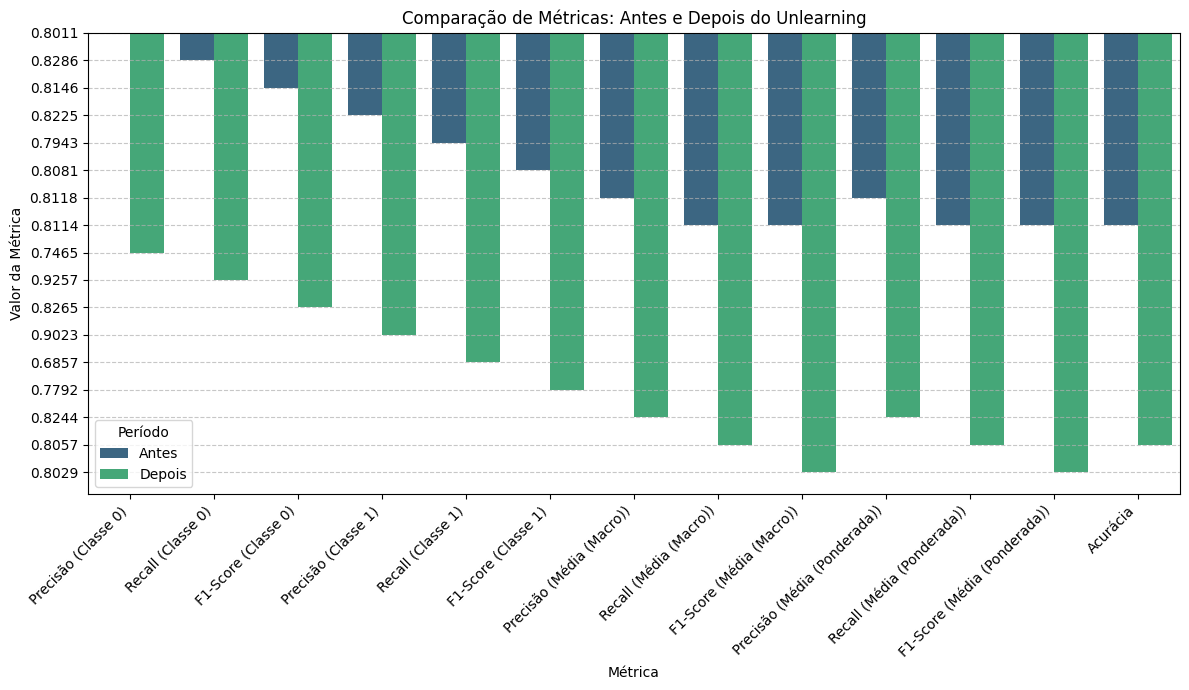

In [ ]:
plot_barras_agrupadas_antes_depois(df_diferenca)

## Geração de grafo de  árvore específica de um modelo

In [ ]:
def plot_tree_graphviz(model, tree_idx, feature_names, class_names, output_dir="/content/drive/MyDrive/Desaprendizado-de-maquina/tree_graphs", shard_idx=0):
    os.makedirs(output_dir, exist_ok=True)

    # Acessar a árvore específica
    tree = model.estimators_[tree_idx]

    # Exportar a árvore como DOT
    dot_data = export_graphviz(
        tree,
        feature_names=feature_names,
        class_names=class_names,
        filled=True,
        rounded=True,
        special_characters=True
    )

    # Criar grafo a partir do DOT
    graph = pydotplus.graph_from_dot_data(dot_data)

    # Salvar como PNG
    output_path = os.path.join(output_dir, f"shard_{shard_idx}_tree_{tree_idx}.png")
    graph.write_png(output_path)
    print(f"Grafo salvo em: {output_path}")

    # Retornar imagem para exibição (opcional, útil no Colab)
    return Image(graph.create_png())

In [ ]:
feature_names = [f"feature_{i}" for i in range(768)]  # Nomes para as 768 dimensões dos embeddings do BERT
class_names = ["class_0", "class_1"]  # Substitua pelos nomes das suas classes

### Gera grafo para a primeira árvore de cada shard

In [ ]:

for shard_idx, model in enumerate(sisa_models_unlearned):
    # Supondo que o modelo já foi treinado
    plot_tree_graphviz(model, tree_idx=0, feature_names=feature_names, class_names=class_names, shard_idx=shard_idx)

Grafo salvo em: /content/drive/MyDrive/Desaprendizado-de-maquina/tree_graphs/shard_0_tree_0.png
Grafo salvo em: /content/drive/MyDrive/Desaprendizado-de-maquina/tree_graphs/shard_1_tree_0.png
Grafo salvo em: /content/drive/MyDrive/Desaprendizado-de-maquina/tree_graphs/shard_2_tree_0.png
Grafo salvo em: /content/drive/MyDrive/Desaprendizado-de-maquina/tree_graphs/shard_3_tree_0.png
Grafo salvo em: /content/drive/MyDrive/Desaprendizado-de-maquina/tree_graphs/shard_4_tree_0.png
Grafo salvo em: /content/drive/MyDrive/Desaprendizado-de-maquina/tree_graphs/shard_5_tree_0.png
Grafo salvo em: /content/drive/MyDrive/Desaprendizado-de-maquina/tree_graphs/shard_6_tree_0.png
Grafo salvo em: /content/drive/MyDrive/Desaprendizado-de-maquina/tree_graphs/shard_7_tree_0.png
Grafo salvo em: /content/drive/MyDrive/Desaprendizado-de-maquina/tree_graphs/shard_8_tree_0.png
Grafo salvo em: /content/drive/MyDrive/Desaprendizado-de-maquina/tree_graphs/shard_9_tree_0.png
Grafo salvo em: /content/drive/MyDrive/D

## Função para extrair e agregar feature importance

Visualizar as árvores de decisão de cada modelo em cada shard como grafos.

Extrair e agregar a importância das features de todos os modelos.

Apresentar os resultados de forma clara, incluindo um gráfico para a importância das features.

In [ ]:
def get_feature_importance_sisa(models, feature_names):
    all_importances = []

    for shard_idx, model in enumerate(models):
        if model is not None:  # Ignorar modelos nulos (shards vazios)
            importances = model.feature_importances_
            all_importances.append(importances)

    # Agrega importâncias (média por feature)
    aggregated_importances = np.mean(all_importances, axis=0)

    # DataFrame para visualização
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': aggregated_importances
    })
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    return importance_df

### ImportÂncia da Features em cada Shard

Modificações na função:
Importâncias por shard: Em vez de apenas agregar as importâncias, a função agora armazena as importâncias de cada shard em all_importances (um array com shape n_shards x n_features).

Coluna Max_Shard: Para cada feature, identifica o shard onde ela tem a maior importância usando np.argmax.
Colunas por shard: Adiciona colunas Shard_0_Importance, Shard_1_Importance, etc., para mostrar a importância de cada feature em cada shard.

Ordenação: O DataFrame é ordenado por Aggregated_Importance (média das importâncias), como na função original.

Gráfico por shard:
* A função plot_feature_importance_by_shard cria um gráfico de barras empilhadas, onde cada barra representa uma feature e cada cor representa a importância dessa feature em um shard específico.
* O gráfico é limitado às top_n features (padrão: 20) para evitar sobrecarga visual, já que você tem 768 features (dimensões do BERT).
* O gráfico é salvo no diretório especificado

Saída do DataFrame:
O DataFrame retornado contém:
* Feature: Nome da feature (feature_0, feature_1).
* Aggregated_Importance: Média da importância da feature em todos os shards.
* Max_Shard: Índice do shard onde a feature tem a maior importância.
* Shard_X_Importance: Importância da feature no shard X (para cada shard).

Interpretação de Max_Shard:
* A coluna Max_Shard indica qual shard dá a maior importância para cada feature. Isso pode ajudar a entender se certas dimensões do embedding do BERT são mais relevantes em subconjuntos específicos do dataset (shards).
* Como os embeddings do BERT são abstratos, a interpretação direta é limitada, mas pode-se usar Max_Shard para investigar padrões nos dados (por exemplo se um shard específico domina a importância de muitas features, pode indicar um subconjunto de dados mais informativo).

Shards vazios:
* A função lida com modelos nulos (shards vazios após unlearning) atribuindo importância zero para aquele shard, garantindo que a agregação não seja afetada.

In [ ]:
def get_feature_importance_sisa_mod(models, feature_names, output_dir="feature_importance_plots"):
    # Lista para armazenar importâncias de cada shard
    all_importances = []

    for shard_idx, model in enumerate(models):
        if model is not None:  # Ignorar modelos nulos (shards vazios)
            importances = model.feature_importances_
            all_importances.append(importances)
        else:
            # Se o shard está vazio, preencher com zeros (ou ignorar na agregação)
            all_importances.append(np.zeros(len(feature_names)))

    # Converter para array NumPy (shape: n_shards x n_features)
    all_importances = np.array(all_importances)

    # Calcular média das importâncias
    aggregated_importances = np.mean(all_importances, axis=0)

    # Identificar o shard com maior importância para cada feature
    max_shard_indices = np.argmax(all_importances, axis=0)

    # Criar DataFrame com importâncias agregadas e shard mais importante
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Aggregated_Importance': aggregated_importances,
        'Max_Shard': max_shard_indices
    })

    # Adicionar colunas para as importâncias de cada shard
    for shard_idx in range(len(models)):
        importance_df[f'Shard_{shard_idx}_Importance'] = all_importances[shard_idx]

    # Ordenar por importância agregada
    importance_df = importance_df.sort_values(by='Aggregated_Importance', ascending=False)

    # Criar diretório para salvar gráficos
    os.makedirs(output_dir, exist_ok=True)

    # Plotar as top N features com importâncias por shard
    def plot_feature_importance_by_shard(importance_df, top_n=20, output_path=f"{output_dir}/feature_importance_by_shard.png"):
        plt.figure(figsize=(12, 6))
        top_features = importance_df.head(top_n)
        x = np.arange(len(top_features))
        width = 0.8 / len(models)  # Ajustar largura das barras

        for shard_idx in range(len(models)):
            plt.bar(x + shard_idx * width, top_features[f'Shard_{shard_idx}_Importance'],
                    width, label=f'Shard {shard_idx}')

        plt.title(f'Top {top_n} Feature Importances por Shard')
        plt.xlabel('Features')
        plt.ylabel('Importance')
        plt.xticks(x + width * (len(models) - 1) / 2, top_features['Feature'], rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.savefig(output_path)
        plt.show()
        print(f"Gráfico salvo em: {output_path}")

    plot_feature_importance_by_shard(importance_df)

    return importance_df

## Plotagem das feature importance

In [ ]:
def plot_feature_importance(importance_df, top_n=20, output_path="feature_importance.png"):
    plt.figure(figsize=(10, 6))
    plt.bar(importance_df['Feature'][:top_n], importance_df['Importance'][:top_n])
    plt.title(f"Top {top_n} Feature Importances (Aggregated across SISA Shards)")
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()
    print(f"Gráfico salvo em: {output_path}")

In [ ]:
feature_names = [f"feature_{i}" for i in range(768)]  # Nomes das features (embeddings do BERT)
importance_df = get_feature_importance_sisa(sisa_models_unlearned, feature_names)

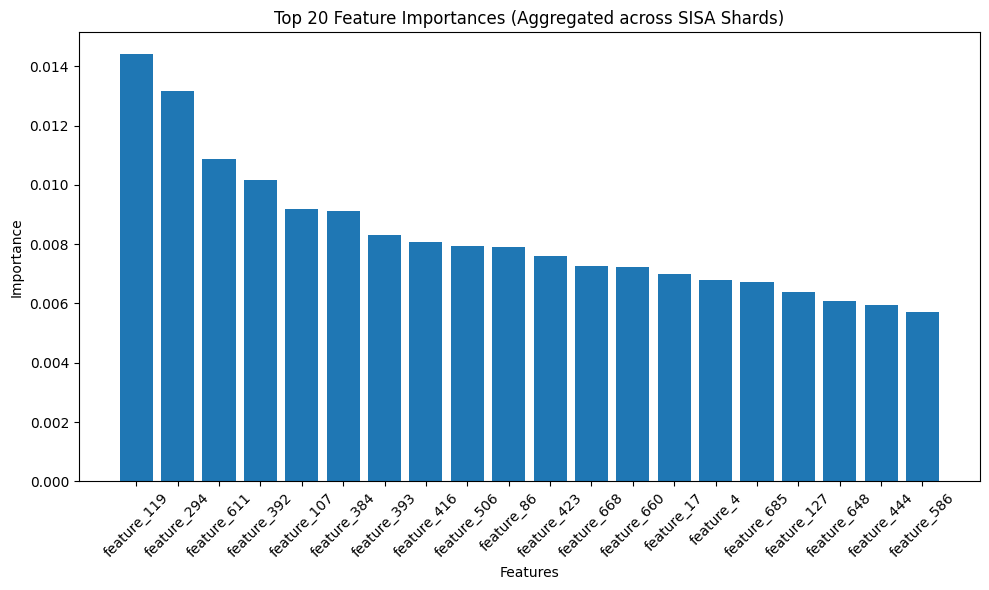

Gráfico salvo em: feature_importance.png


In [ ]:
plot_feature_importance(importance_df, top_n=20)

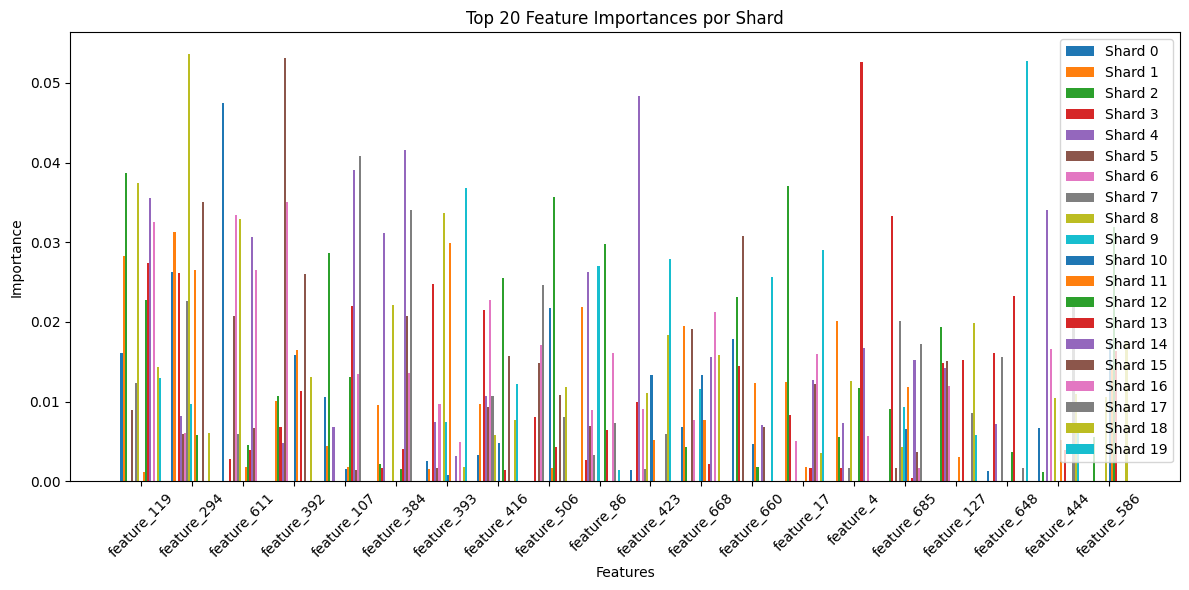

Gráfico salvo em: /content/drive/MyDrive/Desaprendizado-de-maquina/feature_importance_plots/feature_importance_by_shard.png


In [ ]:
importance_df_por_shard = get_feature_importance_sisa_mod(sisa_models_unlearned,
                                                feature_names,
                                                output_dir="/content/drive/MyDrive/Desaprendizado-de-maquina/feature_importance_plots")

In [ ]:
print(importance_df.head(20))  # Mostra as 20 features mais importantes


         Feature  Importance
119  feature_119    0.014425
294  feature_294    0.013173
611  feature_611    0.010880
392  feature_392    0.010163
107  feature_107    0.009178
384  feature_384    0.009108
393  feature_393    0.008304
416  feature_416    0.008059
506  feature_506    0.007938
86    feature_86    0.007901
423  feature_423    0.007600
668  feature_668    0.007256
660  feature_660    0.007222
17    feature_17    0.006995
4      feature_4    0.006779
685  feature_685    0.006722
127  feature_127    0.006400
648  feature_648    0.006079
444  feature_444    0.005937
586  feature_586    0.005710


In [ ]:
importance_df_por_shard

,Feature,Aggregated_Importance,Max_Shard,Shard_0_Importance,Shard_1_Importance,Shard_2_Importance,Shard_3_Importance,Shard_4_Importance,Shard_5_Importance,Shard_6_Importance,...,Shard_10_Importance,Shard_11_Importance,Shard_12_Importance,Shard_13_Importance,Shard_14_Importance,Shard_15_Importance,Shard_16_Importance,Shard_17_Importance,Shard_18_Importance,Shard_19_Importance
119,feature_119,0.014425,2,0.016108,0.028224,0.038630,0.000000,0.000000,0.008928,0.000000,...,0.000000,0.001209,0.022812,0.027390,0.035572,0.000000,0.032506,0.000000,0.014394,0.013007
294,feature_294,0.013173,8,0.026290,0.031270,0.000000,0.026182,0.008208,0.005996,0.006039,...,0.000000,0.026506,0.005766,0.000000,0.000000,0.035092,0.000000,0.000000,0.006033,0.000000
611,feature_611,0.010880,0,0.047526,0.000000,0.000000,0.002833,0.000000,0.020777,0.033418,...,0.000000,0.001781,0.004591,0.003975,0.030655,0.006740,0.026501,0.000000,0.000000,0.000000
392,feature_392,0.010163,5,0.000000,0.010118,0.010714,0.006757,0.004793,0.053154,0.034999,...,0.015852,0.016439,0.000000,0.011296,0.000000,0.026043,0.000000,0.000000,0.013096,0.000000
107,feature_107,0.009178,17,0.010575,0.004407,0.028650,0.000000,0.006792,0.000000,0.000000,...,0.001600,0.001745,0.013143,0.021978,0.039006,0.001446,0.013428,0.040796,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673,feature_673,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
415,feature_415,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
363,feature_363,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
64,feature_64,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


###Nota

Agregação: A importância das features é agregada usando a média (np.mean). Outras estatísticas ( mediana, máximo) podem ser usadas dependendo do caso. A média é comum, pois reflete a contribuição relativa de cada feature em todos os shards.
Interpretação com embeddings do BERT: As features são as dimensões do embedding ( 768 para bertimbau), que não têm interpretações semânticas diretas. Para uma análise mais interpretável, pode ser usadoo:

* Agrupar dimensões do embedding usando técnicas como PCA ou t-SNE para reduzir dimensionalidade.

* Mapeamento das dimensões mais importantes para tokens ou contextos específicos, mas isso exige análise avançada ( atenção do BERT).

* Visualização: O gráfico mostra as top_n features mais importantes. Como 768 features são muitas, limitar a visualização às 20 foi importante e tbm uma boa prática.

# Verficação dos indices removidos nos shards

In [ ]:
def verify_structural_unlearning(indices_to_forget, shards_indices, shards_X, shards_y):
    indices_to_forget_set = set(indices_to_forget)
    for shard_idx, indices in enumerate(shards_indices):
        remaining_indices = set(indices)
        common_indices = remaining_indices.intersection(indices_to_forget_set)
        if common_indices:
            print(f"Erro: Shard {shard_idx} ainda contém índices a serem esquecidos: {common_indices}")
        else:
            print(f"Shard {shard_idx} OK: Nenhum índice a ser esquecido encontrado.")
        print(f"Shard {shard_idx} - Tamanho após unlearning: {len(shards_X[shard_idx])} amostras")

In [ ]:
# Supondo que shards_X, shards_y, shards_indices já foram atualizados por unlearn_sisa

verify_structural_unlearning(selecao_para_remocao_LGPD, shards_indices_unlearned, shards_X_unlearned, shards_y_unlearned)

Shard 0 OK: Nenhum índice a ser esquecido encontrado.
Shard 0 - Tamanho após unlearning: 240 amostras
Shard 1 OK: Nenhum índice a ser esquecido encontrado.
Shard 1 - Tamanho após unlearning: 222 amostras
Shard 2 OK: Nenhum índice a ser esquecido encontrado.
Shard 2 - Tamanho após unlearning: 237 amostras
Shard 3 OK: Nenhum índice a ser esquecido encontrado.
Shard 3 - Tamanho após unlearning: 226 amostras
Shard 4 OK: Nenhum índice a ser esquecido encontrado.
Shard 4 - Tamanho após unlearning: 234 amostras
Shard 5 OK: Nenhum índice a ser esquecido encontrado.
Shard 5 - Tamanho após unlearning: 228 amostras
Shard 6 OK: Nenhum índice a ser esquecido encontrado.
Shard 6 - Tamanho após unlearning: 234 amostras
Shard 7 OK: Nenhum índice a ser esquecido encontrado.
Shard 7 - Tamanho após unlearning: 229 amostras
Shard 8 OK: Nenhum índice a ser esquecido encontrado.
Shard 8 - Tamanho após unlearning: 232 amostras
Shard 9 OK: Nenhum índice a ser esquecido encontrado.
Shard 9 - Tamanho após unlea

In [ ]:
indices_presentes_nos_shards = np.array([3475,3495,20])
indices_presentes_nos_shards

array([3475, 3495,   20])

In [ ]:
verify_structural_unlearning(indices_presentes_nos_shards, shards_indices_unlearned, shards_X_unlearned, shards_y_unlearned)

Shard 0 OK: Nenhum índice a ser esquecido encontrado.
Shard 0 - Tamanho após unlearning: 240 amostras
Shard 1 OK: Nenhum índice a ser esquecido encontrado.
Shard 1 - Tamanho após unlearning: 222 amostras
Shard 2 OK: Nenhum índice a ser esquecido encontrado.
Shard 2 - Tamanho após unlearning: 237 amostras
Shard 3 OK: Nenhum índice a ser esquecido encontrado.
Shard 3 - Tamanho após unlearning: 226 amostras
Shard 4 OK: Nenhum índice a ser esquecido encontrado.
Shard 4 - Tamanho após unlearning: 234 amostras
Erro: Shard 5 ainda contém índices a serem esquecidos: {np.int64(3495)}
Shard 5 - Tamanho após unlearning: 228 amostras
Shard 6 OK: Nenhum índice a ser esquecido encontrado.
Shard 6 - Tamanho após unlearning: 234 amostras
Shard 7 OK: Nenhum índice a ser esquecido encontrado.
Shard 7 - Tamanho após unlearning: 229 amostras
Shard 8 OK: Nenhum índice a ser esquecido encontrado.
Shard 8 - Tamanho após unlearning: 232 amostras
Shard 9 OK: Nenhum índice a ser esquecido encontrado.
Shard 9 - 